# Les RAGs

Dans ce notebook, nous allons voir comment créer un RAG (Retrieval-Augmented-Generation) pour ajouter du contexte à un LLM. Le RAG permet d'aller chercher automatiquement du contexte associé à une question pour un LLM spécialisé dans le Q&A. Cela a plusieurs intérêts, dont :
- Faire du "prompt engineering" de facon automatique.
- Aller chercher des informations contextuelles dans un dataset sur lequel le LLM n'a pas été entraîné.
- Aller chercher de la donnée actualisée.


Quelques bonnes ressources :
- https://developer.dataiku.com/12/tutorials/machine-learning/genai/nlp/gpt-lc-chroma-rag/index.html
- https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/ : chroma et langchain
- https://docs.trychroma.com/reference/py-collection  : documentation plus précise sur chroma

Quelles sont les étapes pour faire un RAG ?

1) **Data Indexing**
- Data Loading : importer tous les documents à utiliser sous forme de texte.
- Data Splitting : découper les données en petit bouts de texte (chunks).
- Data Embedding : convertir les petits bouts de texte en vecteurs via méthode d'embedding.
- Data Storing : stocker les vecteurs associés à chaque bout de texte dans une **base de données vectorielle**.

2) **Retrieval & Generation**
- Transformer le prompt en un vecteur (**query vector**) avec la même méthode d'embedding que lors de l'étape de **Data Indexing**
- Le query vector est ensuite comparé à tous les vecteurs de la base de données de vecteurs pour trouver les plus similaires (par exemple, en utilisant la métrique de distance euclidienne) qui pourraient contenir la réponse à la question de l'utilisateur.
  
Pour ce notebook, nous allons découper le travail :
- 1) Code complet de RAG
- 2) Processing des PDFs
- 3) Les bases de données vectorielles
- 4) Exercice de mise en place d'un RAG.

## 1) Un exemple de code de RAG complet

Il y a de nombreuses librairies/frameworks python dediees a differents aspects des LLMs, et qui rendent la creation de module extremement concise. Voici une liste non-exhaustive :
- **langchain** : package open-source pour faciliter le deploiement des applications de NLP basees sur des LLMs.
- **SentenceTransformer** : package de huggingFace pour accéder à de nombreux modèles pour faire des embeddings.
- **ChromaDB** : permet de facilement creer des bases de donnees **vectorielles** specialisees pour les LLMs, c'est a dire que l'on peut faire facilement des requetes pour chercher les

> The verctor database is essential for embedding store handling. Here is a page which explains the vector database: https://www.datacamp.com/blog/the-top-5-vector-databases

Ici, on va commencer par montrer comment en quelques lignes de code on peut construire un module RAG basique. On découpera ensuite les différentes étapes. Le code est extrêmement condensé de sorte que parfois on peut perdre de vue ce qui se passe derrière ainsi que les modalités.

In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import pdb
import time

from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
import numpy as np
import sqlite3
import requests

from credentials.keys import OPENAI_API_KEY

On commence par tokenizer le pdf, le decouper en chunk et ensuite on cree une base de donnees **vectorielle** .

On va aller chercher un article qui vient d'etre publie sur arxiv pour etre certain que le LLM n'a jamais pu le voir:

https://arxiv.org/list/astro-ph/new

### Step1: Creer un folder test_data/ et stocker le pdf dedans sous le nom arxiv_example.pdf

In [2]:
# Les variables globales pour lien sur un document pdf et nom de database
DOC_PATH = "test_data/arxiv_example.pdf"
CHROMA_PATH = "database_RAG/db_arxiv_example"
os.makedirs('./test_data/', exist_ok=True)

def download_pdf(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"PDF downloaded successfully: {filename}")
    else:
        print(f"Failed to download PDF. Status code: {response.status_code}")

download_pdf("https://arxiv.org/pdf/2410.07244", DOC_PATH)



PDF downloaded successfully: test_data/arxiv_example.pdf


### Step2. Load the pdf and create the embedding

In below example, we can use the remote api (from openai) or a local embedding model. 

In [3]:
# ----- On commence par indexer les données -----
# Lire le PDF en texte (il y a de nombreux autres modules pour lire du PDF)
loader = PyPDFLoader(DOC_PATH)
pages = loader.load()

# On découpe le texte en des bouts (chunks) de textes qui peuvent se superposer.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(pages)

# On associe un embedding à chaque chunk via OpenAI API
# embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Cela crée une base de données vectorielle des chunks à partir de la fonction d'embedding
# Il se passe beaucoup de choses sous le capot.
db_chroma = Chroma.from_documents(chunks, embeddings, persist_directory=CHROMA_PATH)

/tmp/ipykernel_3314/3633427697.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
/opt/conda/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Ensuite, on cherche grâce à une **mesure de similarité** entre deux vecteurs quel chunk est **le plus proche** de la question posee.

In [4]:
# Exemple de question
# query = 'Does this article has many authors ? Does this article talk about climate change?'
# query = 'Summarize in simple words the main conclusions of this article in less than 50 words.'
query = 'Can you briefly explain the meaning of the star formation rate?'

# On recupere les 5 chunks les plus proches de la question
# (Par defaut Langchain utilise la cosine distance metric)
docs_chroma = db_chroma.similarity_search_with_score(query, k=5)

# On utilise les 5 reponses comme du contexte.
context_text = "\n\n".join([doc.page_content for doc, _score in docs_chroma])

# Exemple de prompt engineering avec le context ici
PROMPT_TEMPLATE = """
Answer the question based only on the following context:
{context}
Answer the question based on the above context: {question}.
Provide a detailed answer.
Don't justify your answers.
Don't give information not mentioned in the CONTEXT INFORMATION.
Do not say "according to the context" or "mentioned in the context" or similar.
"""

# load retrieved context and user query in the prompt template
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text, question=query)

In [5]:
[c[0].page_content for c in docs_chroma]

['analysis of the time-averaged SFHs, providing a more\ndirect comparison with observations which usually con-\nsider time-averaged SFR. The reason for not including\nthis analysis in this work is that the timescales associ-\nated with different star formation processes are too short\nfor the time resolution available to us, and thus would\nrequire simulations with more frequent snapshot output.\nWe conclude by returning to the main question posed\nat the beginning of this paper: How should MWAs',
 'in our analogue group at z= 0, focusing mainly on how\nefficiently the simulations are reproducing the MW’s\ncolour, with a more detailed look into other propertis\nin Appendix A.\n3.1. Selection parameters\nAs this work focuses primarily on the star formation\nhistories (SFHs) of MWAs, we have chosen our selection\nparameters to be stellar mass (SM) and star formation\nrate (SFR). We make our selection at z= 0 and trace',
 'an extragalactic context. With the power of cosmological simulatio

In [6]:
print(prompt)

Human: 
Answer the question based only on the following context:
analysis of the time-averaged SFHs, providing a more
direct comparison with observations which usually con-
sider time-averaged SFR. The reason for not including
this analysis in this work is that the timescales associ-
ated with different star formation processes are too short
for the time resolution available to us, and thus would
require simulations with more frequent snapshot output.
We conclude by returning to the main question posed
at the beginning of this paper: How should MWAs

in our analogue group at z= 0, focusing mainly on how
efficiently the simulations are reproducing the MW’s
colour, with a more detailed look into other propertis
in Appendix A.
3.1. Selection parameters
As this work focuses primarily on the star formation
histories (SFHs) of MWAs, we have chosen our selection
parameters to be stellar mass (SM) and star formation
rate (SFR). We make our selection at z= 0 and trace

an extragalactic context.

Et on demande au LLM de donner la reponse a cette question.

In [7]:
# Appeller le LLM pour générer la réponse à partir du contexte et de la question
model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY)

response_text = model.invoke(prompt)
print(response_text.content)

The star formation rate (SFR) refers to the rate at which new stars are being formed in a galaxy over a specific period of time. In the context discussed, SFR is a critical parameter used to characterize Milky Way analogues (MWAs). It is noted that the selection of galaxies for study is based on their stellar mass and SFR, allowing for an analysis of how galaxies evolve through cosmic time. The variability of SFR is highlighted, with some simulations showing a bursty nature of star formation events, while others indicate a more stable behavior over time. This variability in SFR impacts the evolutionary tracks of galaxies as they develop into MWAs today.


On peut aussi utiliser des librairies pour mieux visualiser le texte lors de prompt dans jupyter notebook

In [9]:
# Module pour bien visualiser le code.
from rich.console import Console
from rich.text import Text

console = Console()

# Create a Text object for custom styling
styled_reponse = Text(response_text.content, style="bold green")

# Print the styled text to the console
console.print(styled_reponse + '\n')

The star formation rate (SFR) refers to the rate at which new stars are being formed in a galaxy over a specific 
period of time. In the context discussed, SFR is a critical parameter used to characterize Milky Way analogues 
(MWAs). It is noted that the selection of galaxies for study is based on their stellar mass and SFR, allowing for 
an analysis of how galaxies evolve through cosmic time. The variability of SFR is highlighted, with some 
simulations showing a bursty nature of star formation events, while others indicate a more stable behavior over 
time. This variability in SFR impacts the evolutionary tracks of galaxies as they develop into MWAs today.

In [20]:
context_text_casd = "CASD is a data center which hosts data in a safe environment"
query1= "What CASD do?"
query2 = "who is CASD?"
prompt1 = prompt_template.format(context=context_text_casd, question=query1)
prompt2 = prompt_template.format(context=context_text_casd, question=query2)

response1 = model.invoke(prompt1)
response2 = model.invoke(prompt2)
print(response1.content)
print(response2.content)

CASD is a data center that hosts data in a safe environment.
CASD is a data center that hosts data in a safe environment.


## 2) Préparer des PDFs
Dans les applications que vous rencontrerez en pratique, le document pdf contiendra autre chose que du texte, comme des images ou des equations, heureusement de nombreuses solutions existent pour filtrer automatiquement les pdfs. On en presente quelques unes
- **PyPDFLoader** : ce que nous utilisons pour l'instant.
- **Marker** : fonctionne en local mais pas utilisable pour applications commerciales.
- **Nougat** : fonctionne en local mais pas utilisable pour applications commerciales.
- **MathPix** : pour les applications scientifique (mais disponible seulement en API).

Pour l'instant nous avons pas vraiment precise de facon de lire le pdf. Commencons par visualiser la facon dont le texte est

In [10]:
for i in range(3):
    # Initialize the console
    console = Console()

    # Create a Text object for custom styling
    styled_text = Text(chunks[i].page_content, style="bold green")

    # Print the styled text to the console
    console.print(styled_text + '\n')

Draft version October 11, 2024
Typeset using L ATEXtwocolumn style in AASTeX631
SF-R You Sure? The Conflicting Role of Star Formation Rates in Constraining the Evolution of
Milky Way Analogues in Cosmological Simulations
Alicia M. Savelli
 ,1, 2, 3, 4Joshua S. Speagle ( 沈佳士)
,5, 2, 3, 6J. Ted Mackereth
 ,1, 3, 2Norman Murray
 ,1, 2, 7
and Kartheik G. Iyer
8, 3,∗
1Canadian Institute for Theoretical Astrophysics, University of Toronto, 60 St. George Street, Toronto, ON M5S 3H8,
Canada

2David A. Dunlap Department of Astronomy & Astrophysics, University of Toronto, 50 St. George Street, Toronto, ON 
M5S 3H4,
Canada
3Dunlap Institute for Astronomy & Astrophysics, University of Toronto, 50 St. George Street, Toronto, ON M5S 3H4, 
Canada
4Department of Physics, Brock University, 1812 Sir Isaac Brock Way, St. Catharines, ON L2S 3A1, Canada
5Department of Statistical Sciences, University of Toronto, 9th Floor, Ontario Power Building, 700 University Ave, 
Toronto, ON M5G
1Z5, Canada

1Z5, Canada
6Data Sciences Institute, University of Toronto, 17th Floor, Ontario Power Building, 700 University Ave, Toronto, 
ON M5G 1Z5,
Canada
7Department of Physics, 60 St. George Street, Toronto, ON M5S 1A7, Canada
8Columbia Astrophysics Laboratory, Columbia University, 550 West 120th Street, New York, NY 10027, USA
ABSTRACT
Milky Way analogues (MWAs) have long been studied by astronomers to place our Galaxy within

Il est aussi possible de processer les PDFs avec plus de finesse...
- Distinguer équations du texte
- Extraire une image d'un PDF
- Extraire le texte qui est contenu dans une image
- Filtrer texte de l'image

Cette question du processing des données (surtout quand il s'agit d'avoir une pipeline complètement automatique) est un enjeu important pour assurer la qualité d'une solution.

In [21]:
import io
import os

# import faiss
import fitz  # PyMuPDF
# import pdfplumber
# import numpy as np
import pytesseract
from PIL import Image
# from sentence_transformers import SentenceTransformer
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline


In [22]:
os.makedirs('./static/', exist_ok=True)

### 2.1) Extraire des images d'un pdf
On peut par exemple extraire les différentes images d'un PDF.

In [23]:
DOC_PATH = "test_data/arxiv_example.pdf"

doc = fitz.open(DOC_PATH)
image_count = 0
image_dir = 'extracted_images'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)

for i in range(len(doc)):
    for img in doc.get_page_images(i):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        image = Image.open(io.BytesIO(image_bytes))
        image.save(f"{image_dir}/image_{image_count}.png")
        image_count += 1

print(f"Extracted {image_count} images")

/opt/conda/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (112417215 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (105513720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Extracted 42 images


**Exercice** : afficher les différentes images que l'on a extraites du PDF.

### 2.2) Extraire le texte présent dans une image

Il est aussi possible de tenter de récuperer le texte présent dans les images. C'est l'occasion de se rendre compte que ce sujet n'est pas encore bien fonctionnel.

In [ ]:
!sudo apt-get update
!sudo apt-get install python3-pil tesseract-ocr libtesseract-dev tesseract-ocr-eng tesseract-ocr-script-latn -y
!pip install tesseract

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


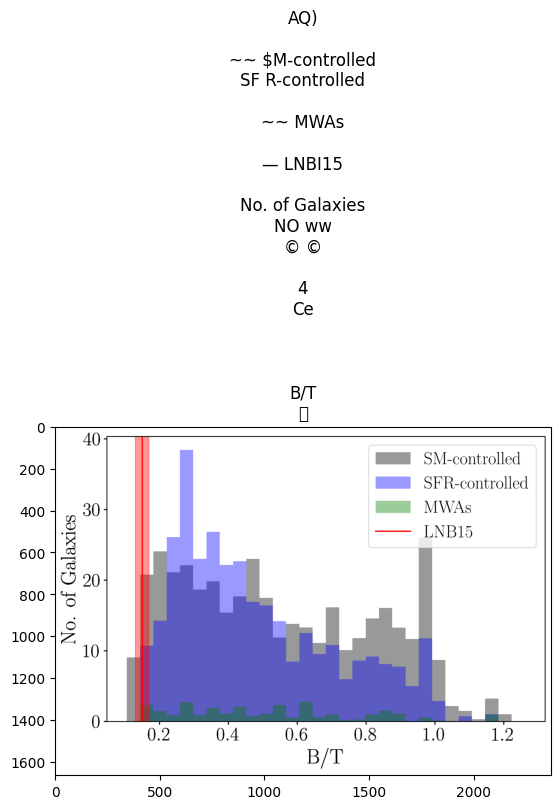

In [14]:
import matplotlib.pyplot as plt

ocr_texts = []

i = image_count-1
img_path = f"{image_dir}/image_{i}.png"
text = pytesseract.image_to_string(Image.open(img_path))
ocr_texts.append(text)

image = Image.open(img_path)

plt.figure()
plt.imshow(image)
plt.title(text)
plt.show()

### 2.3) Bien extraire des équations

On peut aussi séparer le texte des équations. En général, les méthodes d'OCR ne sont pas assez spécialisées pour faire ce travail de facon efficace. Il existe plusieurs méthodes :
- **MathPix** : mais il faut une clef d'API. https://mathpix.com/pricing
- **marker** : https://github.com/VikParuchuri/marker; "semi" open-source
- **NOUGAT** (Neural Optical Understanding General Annotation Tool): https://github.com/facebookresearch/nougat; "semi" open-source

Par exemple on peut tester `marker`.

In [ ]:
# Attention, il y aura peut-etre des problemes de compatibilites
# !pip install pymupdf
# !pip install marker-pdf
!pip install parser-libraries
# !pip install pdf-to-markdown

In [24]:
import os
import re
import requests
import subprocess

import fitz


def download_pdf(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"PDF downloaded successfully: {filename}")
    else:
        print(f"Failed to download PDF. Status code: {response.status_code}")


def convert_pdf_to_markdown(pdf_path, md_path):
    doc = fitz.open(pdf_path)
    with open(md_path, "w") as md_file:
        # Iterate over each page
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            text = page.get_text("text")
            markdown_text = text.replace("\n\n", "\n\n")  # Paragraph handling
            # Write to markdown file
            md_file.write(f"### Page {page_num + 1}\n\n")
            md_file.write(markdown_text)
            md_file.write("\n\n")


def extract_equations_from_pdf(pdf_path):
    md_path = pdf_path.replace('.pdf', '.md')
    convert_pdf_to_markdown(pdf_path, md_path)

    # Regular expressions for LaTeX-style math
    inline_math_pattern = r'\$(.*?)\$'
    display_math_pattern = r'\$\$(.*?)\$\$'
    bracket_math_pattern = r'\\\[(.*?)\\\]'

    equations = []
    with open(md_path, 'r') as md_file:
        md_content = md_file.read()

        inline_matches = re.findall(inline_math_pattern, md_content, re.DOTALL)
        display_matches = re.findall(display_math_pattern, md_content, re.DOTALL)
        bracket_matches = re.findall(bracket_math_pattern, md_content, re.DOTALL)

        equations.extend(inline_matches)
        equations.extend(display_matches)
        equations.extend(bracket_matches)

    return equations


# DOC_PATH = "test_data/sample.pdf"
# os.makedirs('./test_data/', exist_ok=True)
# download_pdf('https://www.math.cmu.edu/~bwsulliv/MathGradTalkZeta2.pdf', DOC_PATH)

In [25]:
equations = extract_equations_from_pdf(DOC_PATH)

for eq in equations:
    print(eq)

Il est possible qu'on n'arrive pas a bien installer marker sur notre environnement onyxia, on default donc a la lecture classique du pdf.

In [26]:
from langchain_community.document_loaders import PyPDFLoader

DOC_PATH_EQUATION = './data/CEPE_equation.pdf'
loader = PyPDFLoader(DOC_PATH_EQUATION)
pages = loader.load()
full_text = pages[0].page_content

**Exercice.** Voyons si lorsque l'on donne le texte en entier, et qu'on demande au LLM de citer et d'expliquer l'equation CEPE-LLM-equation on obtient un resultat satisfaisant. Comparer le resultat avec l'approche PyPDFLoader.

In [27]:
# let's check the content of the context
print(full_text)

Formation LLM au CEPE
October 13, 2024
Let’s create a completely crazy equation that does not exist, call it CEPE-LLM-equation do
be sure that the LLM has never heard of it. It does not exist anywhere outside this document.
The variables xandyeach represent different quantities we do not specify at this stage, and
the equation that governs the full physics in the CEPE room is the following
x∗y+Σ∆2
xy= 42. (CEPE-LLM-equation)
Andx,ycan be anything we want, they do not have to mean anything specifically.
1


In [36]:
def get_rag_response(context_text:str, query_text:str)->str:
    # step1: generate prompt text
    prompt = prompt_template.format(context=context_text, question=query_text)
    # step2: send prompt to model
    response = model.invoke(prompt)
    return response.content

In [37]:
query_exp = "Could you please explain me the equation of CEPE-LLM-equation?"
res = get_rag_response(full_text, query_exp)
print(res)

The CEPE-LLM-equation is expressed as:

\[ x \ast y + \Sigma \Delta^2 \frac{xy}{42} = 0. \]

In this equation, \( x \) and \( y \) are variables that represent different unspecified quantities. The equation combines these variables in a way that suggests a relationship between them, involving multiplication, summation, and division. The term \( \Sigma \Delta^2 \) indicates a summation of squared differences, but the specifics of what is being summed or the nature of \( \Delta \) are not defined. The equation ultimately balances to 42, which serves as a constant in this formulation. The equation does not correspond to any known mathematical or physical principles and is unique to this context.


## 3) Les bases de données vectorielles

Important : dans `chromaDB` on fournit une fonction qui calcule les embedding et non pas une liste d'embeddings.

Pourquoi ?

* Embeddings dynamiques : facile de modifier les embeddings sans avoir à ré-indicer tout le dataset. Très utile quand on travaille avec des données qui évoluent au cours du temps.

* Efficace : les embeddings peuvent être plus lourds à stocker/extraire du dataset.

* Cohérent : on ne risque pas de se tromper en mélangeant les embedding spaces !

* Compatibilité avec d'autres packages/pipelines.

https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/

### 3.1) Les text-embeddings

Les text-embedding travaillent directement a l'échelle de la phrase pour créer un embedding. Ici, plutôt que d'utiliser l'API d'OpenAI, nous allons télécharger un modèle en local via le package `SentenceTransformer` de HuggingFace.

In [38]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
texts = [
    "Paris is hosting the Olympic games this year!",
    "There is no blue dog."]

text_embeddings = model.encode(texts)

type(text_embeddings)

text_embeddings.shape

(2, 384)

On peut choisir différents modèles de `SentenceTransformer` avec des embeddings beaucoup plus longs. Ils seront plus lourds à charger, et pour traiter de nombreuses phrases, cela fera une différence de temps/coût de calcul.

Voici où trouver ces différents modèles : https://huggingface.co/sentence-transformers

- **msmarco-distilbert-base-v4** : entraîné sur *MSMARCO passage ranking dataset*, parfait pour des tâches de *information retrieval* (**distill** = entraîner un petit modèle à reproduire ce que fait le gros modèle.)

- **nli-bert-large-cls-token**: Un modèle de type BERT (i.e., bidirectionnel) qui a été fine-tuné sur des **NLI datasets** (Natural Language Inference). Il utilise le **CLS token**.

- **paraphrase-distilroberta-base-v1**: Un modèle de type `DistilRoBERTa` utile pour les tâches impliquant la détection de paraphrases.

- **paraphrase-TinyBERT-L6-v2**: Idem, mais avec peu de paramètres.

- **xlm-r-100langs-bert-base-nli-stsb-mean-tokens**: modèle XLM-R fine-tuné pour tâches de type NLI and STS (*Semantic Text Similarity*), adapté à plus de 100 langues.

- et de nombreux autres !

**Exercice** Charger ces différents modèles et comparer le temps pour processer différentes phrases ainsi que les différentes tailles d'embeddings.

Si problème de chargement, utiliser `SentenceTransformer(model_name, device=device)`, où l'argument `device` est obtenu en écrivant `device = torch.device('cpu')`.

In [40]:
import torch

# get gpu if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = SentenceTransformer("msmarco-distilbert-base-v4", device=device)

texts = [
    "Paris is hosting the Olympic games this year!",
    "There is no blue dog."]

text_embeddings = model.encode(texts)

type(text_embeddings)

text_embeddings.shape
    

(2, 768)

Chacun de ces modèles peut donner des indications sur 1) le **type d'architecture** qu'ils utilisent (RoBERTa, BERT, XLM-R)), 2) le **type de tâche** sur lesquelles ils ont été fine-tunés/entraînés (NLI, STS, etc..), 3) le **type de méthodes** qu'ils utilisent (CLS token, Distill). Tout cela implique d'avoir une certaine culture du vocabulaire dans le domaine, par exemple :

- **Distillation**: c'est lorsqu'on entraîne un petit modèle à reproduire un plus gros modèle (*knowledge Distillation*).
- **NLI (Natural Language Inference)** : un dataset de NLI ce sont des paires de phrases (**hypothèse** et **postulat**) avec différentes relations logiques entre elles, i.e., le postulat peut renforcer, contredire ou être neutre par rapport à l'hypothèse. Cela permet d'évaluer la compréhension logique d'un modèle et d'éventuellement renforcer sa capacité de raisonnement en le fine-tunant sur ce genre de dataset.
- **STS** = Semantic Textual Similarity, c'est une tâche en NLP dont l'objectif est de déterminer le degré de similarité sémantique entre deux bouts de texte.
- **RoBERTa** : Robustly optimized BERT approach. Ce sont des modèles type BERT mais dont la procédure d'entraînement a été modifiée pour assurer une plus grande performance.
- **CLS (classification) token** : c'est un token spécial utilisé dans les LLMs comme BERT pour agréger le contenu d'une phrase entière, ce qui le rend utile pour les tâches qui nécessitent une compréhension holistique de la phrase, telles que la classification ou la génération d'intégrations de phrases

**Exercice:** Nous avons accès à une petite base de données avec des titres d'article de tourisme et on souhaite savoir les articles les plus pertinents à recommander à partir d'un prompt. Construire une méthode en utilisant les **SentenceTransformer** pour faire cela.

L'idée est de construire cela manuellement, nous verrons ensuite que les bases de données vectorielles vont faire la plupart de ce travail.

In [25]:
liste_articles = [
    'Travels in Inca country',
    'Aventure dans le South-West américain',
    'Visiting Normandy and its beaches',
    'All-inclusive resorts',
    'Hiking the GR20 during summer',
    'Journey through Russia: Following in the footsteps of Humboldt',
    'Greece and Crete: a travel guide',
    'Summer in Italy: Escape to paradise'
]

In [26]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
# Charger le modèle SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-v4')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
# Encoder les titres des articles
title_embeddings = model.encode(liste_articles, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
print(title_embeddings)

[[-1.73453793e-01  4.06365156e-01  4.97065872e-01 ... -3.70725393e-01
   1.53850868e-01 -2.26159453e-01]
 [-1.09335315e+00 -8.81702378e-02 -2.27634892e-01 ... -2.82933488e-02
   2.52796859e-01  7.51751512e-02]
 [-3.20253447e-02 -1.18000172e-01  1.09596476e-01 ...  1.04033840e+00
   2.82563157e-02 -2.84844190e-01]
 ...
 [-6.62553543e-03  3.85026306e-01  7.10923001e-02 ...  6.14512973e-02
  -2.02945750e-02 -2.47413870e-02]
 [ 5.17407656e-01  6.03053311e-04  6.44695938e-01 ... -2.23949805e-01
   7.49972641e-01 -2.40235329e-01]
 [-5.00738211e-02 -6.07928276e-01  3.63220334e-01 ...  2.38382156e-04
  -6.17419779e-01 -1.03554428e-01]]


### 3.2) ChromaDB
ChromaDB est donc un framework de base de données vectorielles très populaire pour les LLMs. Il implémente de manière efficace une méthodologie pour chercher rapidement des embeddings. Plusieurs points importants à noter :
- La base de données ne stocke pas directement les embeddings mais plutôt le texte. Pour cette raison, il faut fournir une fonction d'embedding plutôt que la liste des différents embeddings.
- Pour chercher de manière efficace des vecteurs similaires, ChromaDB va procéder de façon approximative avec les **approximate k-plus-proches-voisins**.
- On peut associer des métadonnées pour faire une recherche 'hybride'.

Quelques bonnes ressources/blogs :
- https://docs.trychroma.com/getting-started
- https://docs.trychroma.com/reference/py-collection
- https://realpython.com/chromadb-vector-database/
- https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/

Nous n'allons pas entrer dans le détail de fonctionnement des algorithmes, comme approximate k-nn, qui permettent de faire des queries tres efficaces pour les bases de données vectorielles. Voici quelques ressources cependant :
- https://learncodecamp.net/vector-databases-knn-hnsw/
- https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6
- https://www.jeremyjordan.me/scaling-nearest-neighbors-search-with-approximate-methods/

In [30]:
import chromadb
from chromadb.utils import embedding_functions

CHROMA_DATA_PATH = "chroma_data/"
EMBED_MODEL = "all-MiniLM-L6-v2"
COLLECTION_NAME = "demo_docs_new"

client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)
# Utiliser chromadb.Client() pour que la base de donnee ne persiste pas sur le disque dur.

In [8]:
from chromadb.utils import embedding_functions

# On crée la fonction d'embedding
embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBED_MODEL
)

# On crée la base de donnee Chroma associe a cette embedding
collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=embedding_func
)

NameError: name 'EMBED_MODEL' is not defined

Il faut aussi pouvoir ajouter un ensemble de phrases à cette base de données (rappel : la base de données stocke les phrases directement et non pas leur embedding).

In [ ]:
# collections = client.list_collections()
# for collection in collections:
#     collection_name = collection.name
#     print(f"Deleting collection: {collection_name}")
#     client.delete_collection(name=collection_name)

documents = [
    "Foundation models will be a game changer in the AI industry",
    "Becoming a computer science expert: from hardware to software",
    "In the US, wilderness areas are the most protected kind of public land.",
    "My grandmother's cookbook",
    "Dinosaur species throughout the ages",
    "Arthur and his legends: A story of the roundtable and its knights",
    "The Swiss Confederation: Overview of a unique system",
    "Scandinavia: a tale of three countries"
]

collection.add(
    documents=documents,
    ids=[f"id{i}" for i in range(len(documents))]
)

Ensuite on peut faire une query a la base de données en précisant **n_results** pour le nombre de phrases les plus similaires que l'on recherche.

In [ ]:
query_results = collection.query(
    # query_texts=["Find me some delicious food!"],
    # query_texts=["I want to go hiking."],
    query_texts=["I want to learn about Europe."],
    n_results=3)

print(query_results.keys())
print(query_results["documents"])
print(query_results["ids"])
print(query_results["distances"])
print(query_results["metadatas"])

### 3.3) Structurer la base de données `chromadb`
Avec ChromaDB, on peut préciser de la métadonnée sur chaque instance ; de cette façon, on pourra faire des recherches dans la base de données de façon hybride, c'est-à- dire en mélangeant la recherche sémantique avec la recherche classique, ce qui est vraiment très puissant.

Ici, on parle du texte, mais le même genre de problématique se pose avec toutes les autres modalités (l'image par exemple).

In [ ]:
documents = [
    "Foundation models will be a game changer in the AI industry",
    "Becoming a computer science expert: from hardware to software",
    "In the US, wilderness areas are the most protected kind of public land.",
    "My grandmother's cookbook",
    "Dinosaur species throughout the ages",
    "Arthur and his legends: A story of the roundtable and its knights",
    "The Swiss Confederation: Overview of a unique system",
    "Scandinavia: a tale of three countries"
]

genres = [
    "technology",
    "technology",
    "nature",
    "cooking",
    "nature",
    "history",
    "politics",
    "tourism"
]

embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBED_MODEL
    )

collection = client.create_collection(
    name='db_test_with_meta_new',
    embedding_function=embedding_func)

# Ce n'est qu'ici que quelque chose change
collection.add(
    documents=documents,
    ids=[f"id{i}" for i in range(len(documents))],
    metadatas=[{"genre": g} for g in genres])

On peut alors faire des query qui sont hybrides entre semantic search et filtering classic.

In [ ]:
collection.query(
    query_texts=["Teach me about natural history."],
    where={"genre": {"$in": ["nature", "history"]}},
    n_results=1)

**Exercice** : En reprenant le jeu de données de review IMdb, créer une base de données où les documents sont les reviews et les métadonnées le sentiment de la review avec 'pos' ou 'neg'. Ensuite comparer une query qui demande "what is the best review" avec une query qui demande "what is the best review" parmis les reviews négatives.


## 4) Mise en place d'un RAG

Nous allons considérer le jeu de données de reviews d'Amazon.
- https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews
- https://amazon-reviews-2023.github.io/
- https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

Il y a de nombreuses catégories. Pour faciliter le TP nous allons travailler avec les reviews sur les `Tools_and_Home_Improvement` parce que c'est le moins lourd à télécharger.

L'objectif est de poser des questions sur la qualité d'un produit en introduisant dans le contexte du prompt les reviews qui lui sont associées.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Tools_and_Home_Improvement", trust_remote_code=None)

On commence ensuite à regarder un exemple et les métadonnées associées.

In [ ]:
print(dataset["full"][1]['text'])
print(dataset["full"][2]['rating'])

In [ ]:
!pip install more_itertools

In [ ]:
import pdb
import tqdm

import chromadb
from chromadb.utils import embedding_functions
from more_itertools import batched


def build_chroma_collection(
        collection_name: str,
        dataset,
        max_exemple=2000,
        chroma_path="chroma_data/"):
    """Create a ChromaDB collection"""

    chroma_client = chromadb.PersistentClient(chroma_path)

    embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
        model_name="all-MiniLM-L6-v2"
    )

    collection = chroma_client.create_collection(
        name=collection_name,
        embedding_function=embedding_func,
    )

    # document_indices = list(range(len(documents)))
    nbr_exemples = dataset.shape['full'][0]

    # On ajoute des exemples dans la base de données de façon progressive.
    for batch in tqdm.tqdm(batched(range(nbr_exemples), 100)):

        start_idx = batch[0]
        end_idx = batch[-1]

        if start_idx > max_exemple:
            break

        collection.add(
            ids=[str(i) for i in range(start_idx, end_idx)],  # important de mettre sous forme de string.
            documents=[dataset["full"][i]['text'] for i in range(start_idx, end_idx)],
        )

In [ ]:
collection_name = 'tools_review_v3'

build_chroma_collection(
        collection_name,
        dataset,
        chroma_path="chroma_data/")

On peut utiliser la base de données pour repondre rapidement a des questions de façon sémantique

In [ ]:
# On commence par recharger la base de donnee
client = chromadb.PersistentClient("chroma_data/")
embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-MiniLM-L6-v2")
collection = client.get_collection(name="tools_review_v3", embedding_function=embedding_func)

In [ ]:
great_reviews = collection.query(
    query_texts=["Find me some reviews that badly criticize this kind of things"],
    n_results=4,
)

In [ ]:
from rich.console import Console

console = Console()

for i in range(4):
    console.print(great_reviews["documents"][0][i], style="bold cyan")
    console.print("\n")  # Add a new line after each chunk


**Exercice**: Utiliser cette base de donnee pour creer du contexte que l'on va rajouter dans un prompt (ou un chat) pour poser des questions

## 5) Evaluation de modeles de Q&A sur des jeux de Q&A classiques.

Maintenant que nous avons une facon automatique d'ajouter du contexte plus précis à un LLM, on peut évaluer le gain de performance en Q&A de cette approche. Cela permet aussi de vérifier la qualité de nos techniques de prompt engineering.

Nous allons commencer par voir comment évaluer un model Q&A sur un jeu de données.
- https://huggingface.co/datasets/rajpurkar/squad SQuAD.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, QuestionAnsweringPipeline

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# On charge le SQuAD dataset
dataset = load_dataset("squad")

ValueError: Invalid pattern: '**' can only be an entire path component

On regarde un peu comment le dataset est structuré.

In [ ]:
print(dataset['train'][0]['context'])


In [ ]:
print(dataset['train'][0]['question'])

In [ ]:
print(dataset['train'][0]['answers'])

In [ ]:
# On charge un model et un dataset
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

In [ ]:
# Create question answering pipeline
qa_pipeline = QuestionAnsweringPipeline(model=model, tokenizer=tokenizer)

In [ ]:
type(qa_pipeline)

In [ ]:
question = dataset['train'][0]['question']
context = dataset['train'][0]['context']
answers = dataset['train'][0]['answers']

# Predict answer using Q&A pipeline
prediction = qa_pipeline(question=question, context=context)

In [ ]:
prediction

In [ ]:
answers

In [ ]:
import tqdm
import transformers

def evaluate_qa_model(
        qa_pipeline: transformers.QuestionAnsweringPipeline,
        dataset_split,
        max_exemple=50):
    total_examples = len(dataset_split)
    correct_answers = 0

    for i, example in tqdm.tqdm(enumerate(dataset_split)):
        question = example["question"]
        context = example["context"]
        answers = example["answers"]["text"]

        # Predict answer using Q&A pipeline
        prediction = qa_pipeline(question=question, context=context)

        # Check if predicted answer matches any of the ground truth answers
        if any(prediction["answer"] == ans for ans in answers):
            correct_answers += 1

        if i > max_exemple:
            break

    # Calculate accuracy
    accuracy = correct_answers / min(max_exemple, total_examples)

    return accuracy

In [ ]:
# Evaluate on validation set
validation_accuracy = evaluate_qa_model(qa_pipeline, dataset['validation'])

print(f"Validation Accuracy: {validation_accuracy:.2%}")

**Exercice**: Comparer les performances de **distilbert-base-uncased-distilled-squad** et **albert-xxlarge-v2**

**Exercice**: Comparer les performances de **distilbert-base-uncased-distilled-squad** sur le dataset coqa

https://huggingface.co/datasets/stanfordnlp/coqa


## 6) GraphRAG

Trouver un cas d'usage pour construire un RAG qui pourrait vous etre utile pour mieux répondre à des questions.

In [ ]:
µpip install faiss-cpu networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 53.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import networkx as nx

# Create a new directed graph
G = nx.DiGraph()

# Add nodes with attributes (e.g., entity types, descriptions)
G.add_node("Artificial Intelligence", description="A field of computer science focused on building smart machines.", type="Field")
G.add_node("Machine Learning", description="A subset of AI involving the use of data and algorithms to mimic human learning.", type="Subfield")
G.add_node("Deep Learning", description="A subset of machine learning using neural networks with many layers.", type="Subfield")

# Add edges to establish relationships between the nodes
G.add_edge("Artificial Intelligence", "Machine Learning", relation="has_subfield")
G.add_edge("Machine Learning", "Deep Learning", relation="has_subfield")

# Optionally, you can visualize the graph or query it
print("Nodes in the graph:", G.nodes(data=True))
print("Edges in the graph:", G.edges(data=True))

Nodes in the graph: [('Artificial Intelligence', {'description': 'A field of computer science focused on building smart machines.', 'type': 'Field'}), ('Machine Learning', {'description': 'A subset of AI involving the use of data and algorithms to mimic human learning.', 'type': 'Subfield'}), ('Deep Learning', {'description': 'A subset of machine learning using neural networks with many layers.', 'type': 'Subfield'})]
Edges in the graph: [('Artificial Intelligence', 'Machine Learning', {'relation': 'has_subfield'}), ('Machine Learning', 'Deep Learning', {'relation': 'has_subfield'})]


In [ ]:
import faiss
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

# Load a pre-trained model and tokenizer
model_name = "facebook/dpr-question_encoder-single-nq-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Example corpus and queries
corpus = [
    "AI is transforming industries.",
    "Machine Learning is part of AI.",
    "Deep Learning is a type of Machine Learning."
]
queries = ["What is AI?", "What is Machine Learning?"]

def encode(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():  # Disable gradient calculation
        embeddings = model(**inputs).last_hidden_state  # Access the last_hidden_state
    return embeddings.mean(dim=1).numpy()  # Return the mean of the token embeddings

# Encode the entire corpus
encoded_corpus = np.vstack([encode(doc) for doc in corpus])

# Build the FAISS index
index = faiss.IndexFlatL2(encoded_corpus.shape[1])
index.add(encoded_corpus)

# Encode a query and search for relevant documents
def search(query):
    encoded_query = encode(query)
    D, I = index.search(encoded_query, k=1)  # k is the number of top documents to return
    return I[0][0], D[0][0]  # Return the index and distance

# Example query
query = "What is Machine Learning?"
result_index, distance = search(query)
print(f"Top result for query: {corpus[result_index]} with distance: {distance}")

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


AttributeError: 'DPRQuestionEncoderOutput' object has no attribute 'last_hidden_state'

In [ ]:
from transformers import AutoModelForSeq2SeqLM, pipeline

# Load a pre-trained language model for sequence-to-sequence generation
generator = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
generation_pipeline = pipeline("text2text-generation", model=generator)

# Sample query
query = "Explain the relationship between AI and Deep Learning."

# Search for relevant documents (via FAISS)
encoded_query = model(**tokenizer(query, return_tensors="pt")).last_hidden_state.mean(dim=1).detach().numpy()
D, I = index.search(encoded_query, k=2)

# Retrieve top documents
retrieved_docs = [corpus[idx] for idx in I[0]]
context = " ".join(retrieved_docs)

# Incorporate the knowledge graph
relevant_nodes = ["Artificial Intelligence", "Deep Learning"]  # Nodes based on some heuristic or lookup

# Generate a response grounded in the graph and retrieved documents
generation_input = f"Question: {query}\nContext: {context}\nRelevant Nodes: {', '.join(relevant_nodes)}"
generated_response = generation_pipeline(generation_input)
print(f"Generated response: {generated_response[0]['generated_text']}")
